# <center> Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

## Знакомство с данными

In [3]:
# Считаем данные и выведем первые 5 строк

df = pd.read_csv('data/bikes_rent.csv')
df.head()


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

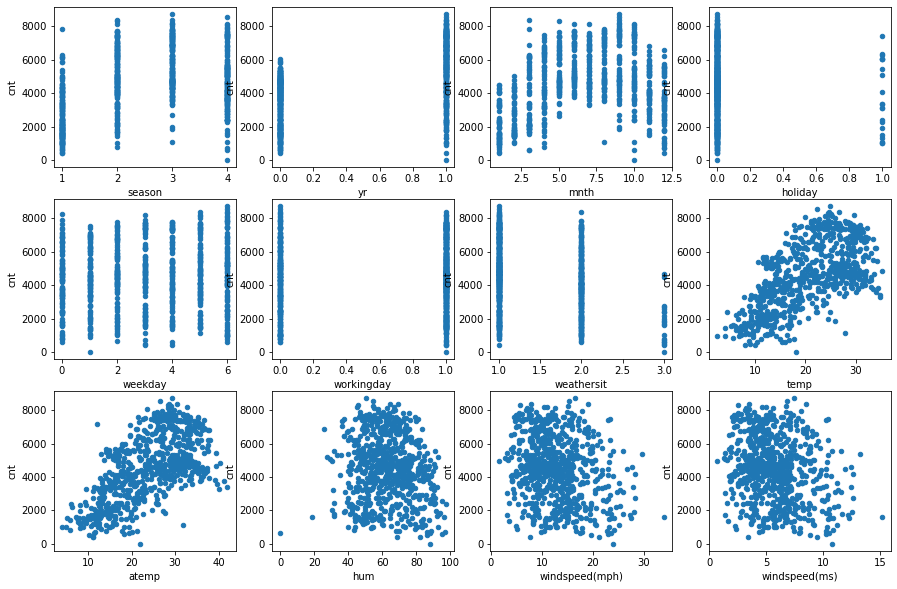

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

1. Характер зависимости числа прокатов от месяца 
   * Начиная с 1-го месяца до 6-го наблюдается прямая зависимость, далее до конца года обратная зависимость. 
1. Один или два признака, от которых число прокатов скорее всего зависит линейно
   * atemp (Температура по ощущениям в Цельсиях) & temp (Температура в Цельсиях)

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона.

In [5]:
# Посчитайем корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:

df_corr_without_last_feature = df.drop('windspeed(ms)', axis = 1).corr()
df_corr_with_last_feature = df.corrwith(df['windspeed(ms)'])

In [6]:
df_corr_without_last_feature

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),cnt
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,0.406100
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,0.566710
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,0.279977
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,-0.068348
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.067443
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,0.061156
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,-0.297391
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,0.627494
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,0.631066
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.100659


In [7]:
df_corr_with_last_feature

season           -0.229046
yr               -0.011817
mnth             -0.207502
holiday           0.006292
weekday           0.014282
workingday       -0.018796
weathersit        0.039511
temp             -0.157944
atemp            -0.183643
hum              -0.248489
windspeed(mph)    1.000000
windspeed(ms)     1.000000
cnt              -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [8]:
# Посчитайем попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
df[['temp','atemp','hum','windspeed(mph)','windspeed(ms)','cnt']].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие).

Напоследок посмотрим средние признаков, чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [9]:
# Выведем средние признаков
df.drop('cnt',axis = 1 ).mean().to_frame().rename(columns = {0:'mean'})

,mean
season,2.496580
yr,0.500684
mnth,6.519836
holiday,0.028728
weekday,2.997264
workingday,0.683995
weathersit,1.395349
temp,20.310776
atemp,23.717699
hum,62.789406


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

## Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [10]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [11]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
linear_coefs = linear_regressor.coef_
print(linear_coefs) # cписок из коэффициентов модели
print()

# вывод пар: фактор & коэфф.
linear_coefs_zip = list(zip(df.columns, linear_regressor.coef_)) 
for coef in linear_coefs_zip:
    print(coef)

[ 5.70871333e+02  1.02196686e+03 -1.41306096e+02 -8.67560791e+01
  1.37227372e+02  5.63922255e+01 -3.30233069e+02  3.67479594e+02
  5.85548348e+02 -1.45605813e+02  1.24577594e+13 -1.24577594e+13]

('season', 570.871332798536)
('yr', 1021.9668618016974)
('mnth', -141.306096437797)
('holiday', -86.75607911307905)
('weekday', 137.2273724065783)
('workingday', 56.392225498944306)
('weathersit', -330.23306926252747)
('temp', 367.4795935910728)
('atemp', 585.5483483543658)
('hum', -145.60581347320988)
('windspeed(mph)', 12457759423164.674)
('windspeed(ms)', -12457759423363.13)


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

Обучим регрессоры Ridge и Lasso с параметрами по умолчанию и убедиися, что проблема с весами решилась.

In [14]:
from sklearn.linear_model import Lasso, Ridge

In [15]:
# Обучим линейную модель с L1-регуляризацией и выведем веса
lasso_regressor = Lasso()
lasso_regressor.fit(X,y)
coefs_lasso = linear_regressor.coef_
lasso_coefs_zip = list(zip(df.columns, lasso_regressor.coef_))
for coef in lasso_coefs_zip:
    print(coef)


('season', 560.2416160308868)
('yr', 1019.4634940657199)
('mnth', -128.73062703678755)
('holiday', -86.15278133371095)
('weekday', 137.34789390496323)
('workingday', 55.2123706413566)
('weathersit', -332.36985696234854)
('temp', 376.3632362096957)
('atemp', 576.5307935045537)
('hum', -144.12915500348612)
('windspeed(mph)', -197.13968940249683)
('windspeed(ms)', -2.8038917916155488e-08)


In [16]:
# Обучим линейную модель с L2-регуляризацией и выведим веса
ridge_regressor = Ridge()
ridge_regressor.fit(X,y)
coefs_ridge = ridge_regressor.coef_
ridge_coefs_zip = list(zip(df.columns, ridge_regressor.coef_))
for coef in ridge_coefs_zip:
    print(coef)

('season', 563.0645722520097)
('yr', 1018.9483787875308)
('mnth', -131.87332028247326)
('holiday', -86.74609799709172)
('weekday', 138.00511117871935)
('workingday', 55.903110375064756)
('weathersit', -332.349788499075)
('temp', 386.45788919197275)
('atemp', 566.3470470600039)
('hum', -145.07132729867007)
('windspeed(mph)', -99.2594410820129)
('windspeed(ms)', -99.25944115412166)


## Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

In [17]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучим регрессор Lasso
# и запишим веса в соответствующую строку матрицы coefs_lasso,
# а затем обучим Ridge и запишим веса в coefs_ridge.
i = 0
for alpha in alphas:
    # Lasso
    lasso_regress = Lasso(alpha)
    lasso_regress.fit(X,y)
    coefs_lasso[i] += lasso_regress.coef_
    # Ridge
    ridge_regress = Ridge(alpha)
    ridge_regress.fit(X,y)
    coefs_ridge[i] += ridge_regress.coef_
    i += 1

Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5, 1.0, 'Ridge')

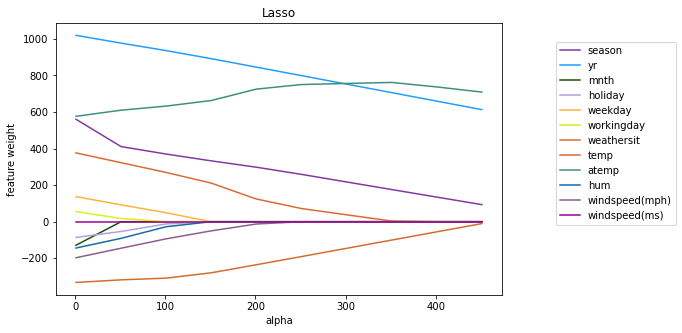

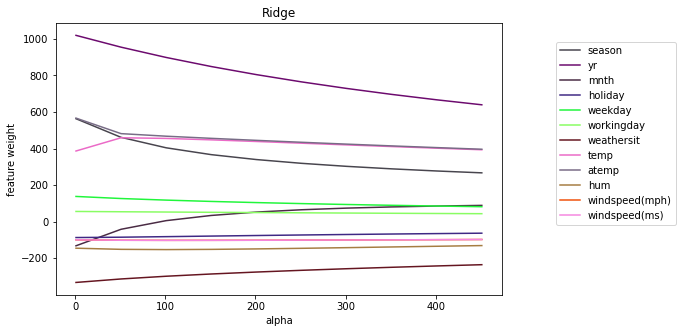

In [18]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратим внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [19]:
from sklearn.linear_model import LassoCV

alpha =  6

('season', 532.0189828413532)
('yr', 1015.06022264306)
('mnth', -100.03952614356595)
('holiday', -83.293959875299)
('weekday', 132.50446549095787)
('workingday', 51.55708561407367)
('weathersit', -330.5598567399811)
('temp', 370.6798550300346)
('atemp', 581.3969310654975)
('hum', -140.00740550068878)
('windspeed(mph)', -191.77140847136099)
('windspeed(ms)', -2.684421513166544e-08)


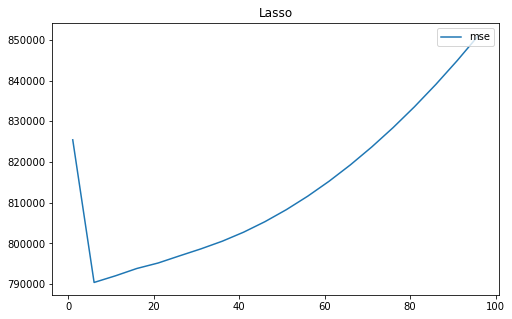

In [20]:
# Обучии регрессор LassoCV на всех параметрах регуляризации из alpha
# Построим график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведим выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)
reg_lasso = LassoCV(alphas = alphas, cv = 3).fit(X,y)

# График зависимости MSE от alpha
mean = reg_lasso.mse_path_.mean(axis = 1)
alpha = reg_lasso.alphas_
plt.figure(figsize=(8, 5))
plt.plot(alpha,mean, label = 'mse')
plt.legend(loc='upper right')
plt.ylabel = ("MSE")
plt.xlabel = ("alpha")
plt.title('Lasso')

# Выведим выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
print('alpha = ', reg_lasso.alpha_)
print()

# Выведим пары "признак-коэффициент" для обученного вектора коэффициентов
for i in list(zip(df.columns,reg_lasso.coef_ )):
    print(i)

In [21]:
for i in zip(reg_lasso.coef_.round(2),df_shuffled.columns):
    print(i)

(532.02, 'season')
(1015.06, 'yr')
(-100.04, 'mnth')
(-83.29, 'holiday')
(132.5, 'weekday')
(51.56, 'workingday')
(-330.56, 'weathersit')
(370.68, 'temp')
(581.4, 'atemp')
(-140.01, 'hum')
(-191.77, 'windspeed(mph)')
(-0.0, 'windspeed(ms)')


Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

In [22]:
# Выведим значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируем столбцы .mse_path_
mse_path = reg_lasso.mse_path_
df_1 = pd.DataFrame({'alpha':alpha,'mse': mse_path[:,0]})
df_2 = pd.DataFrame({'alpha':alpha,'mse': mse_path[:,1]})
df_3 = pd.DataFrame({'alpha':alpha,'mse': mse_path[:,2]})

In [23]:
import seaborn as sns

<AxesSubplot:xlabel='alpha', ylabel='mse'>

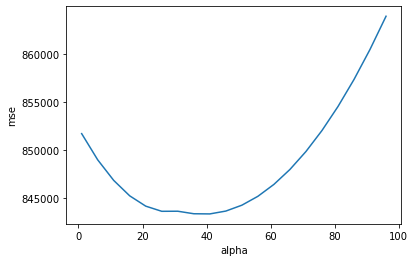

In [24]:
sns.lineplot(x = 'alpha', y = 'mse', data = df_1)

<AxesSubplot:xlabel='alpha', ylabel='mse'>

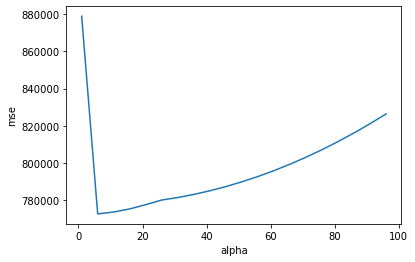

In [25]:
sns.lineplot(x = 'alpha', y = 'mse', data = df_2)

<AxesSubplot:xlabel='alpha', ylabel='mse'>

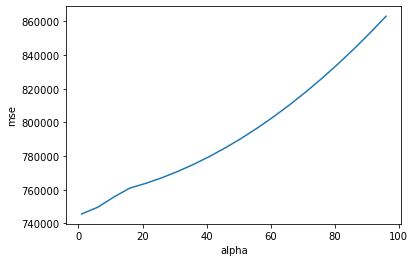

In [26]:
sns.lineplot(x = 'alpha', y = 'mse', data = df_3)

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

## Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.